Based on https://arxiv.org/abs/1508.06576 <br>
Dataset: https://files.fast.ai/data/imagenet-sample-train.tar.gz <br>
The paper outlines a method to separate content and style of an image with much better results than previous efforts through the novel use of CNN features.


In [183]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

#For deterministic optimization 
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [184]:
#To limit GPU memory usage as tensorflow uses all of the memory by default as 
#should be the case in production but not so much during experimentation. 
limit_mem()

Format in tensorflow batch_sizexheightxwidthxchannels 

In [185]:
path = 'data/styleTransfer/imagenet/train/'
spath = 'data/styleTransfer/imagenet/'

## Preview an image

In [186]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)

In [187]:
n = len(fnames); n

19439

In [188]:
fn = fnames[20]

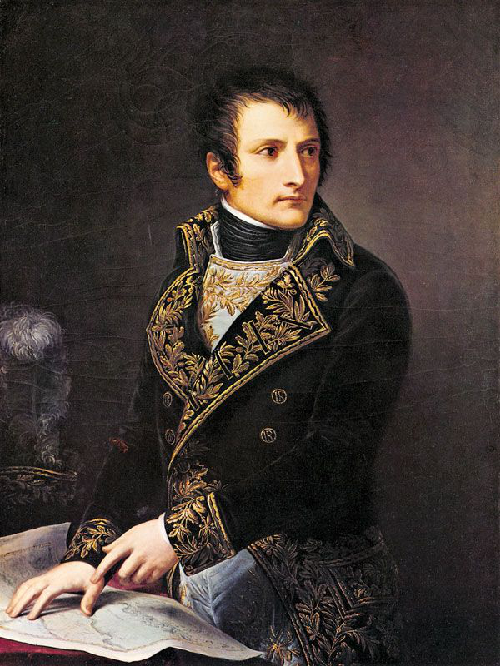

In [202]:
#img=Image.open(fnames[70]); img
img = Image.open(spath+'/data.jpg'); 
img = img.resize(np.divide(img.size,1.2).astype('int32')); img


## Preprocess and deprocess Functions 
in conformance with what the authors of VGG did.
1. Subtract mean of each channel
2. Reverse order of RGB to BGR

In [203]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [204]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [205]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape; shp

(1, 666, 500, 3)

## VGG model

vgg_Avg doess't use maxpooling because maxpooling throws away information which is adverserial for a generative model. Instead, average pooling is used as it doesn't throw away much information. 

In [217]:
model = VGG16_Avg(include_top=False)

In [218]:
#Contains the deterministic optimizer fmin_l_bfgs_b to minimise loss function
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{spath}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [219]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [220]:
#Defining a helper class that takes in a function to split and return separated loss and 
#gradient outputs which is required for the determiistic optimizer.
#Takes in as input the function and shape of the image.  
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
       
    #x is the input image on which loss is calculated
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [221]:
#Elements of a gram martix consists of inner products between vectorised feature maps of a layer. 
def gram_matrix(x):
    #Each row is to be a channel/filter, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels. The division creates an average.
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [222]:
def style_loss(x, targ): return  K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

## Recreate image

Grabbing one of the last layers of the convolution model, we pass an image through it and that becomes our target. A random image is initialised and the loss function minimises the error between the defined vgg layer outputs of the two images. This process will result in a recreation of the important contents in an image.  

In [156]:
layer = model.get_layer('block4_conv1').output

Calculating target activations for the above layer

In [157]:
#Creating a new model that takes the original input and produces an output resembling 
#the layer defined below. 
layer_model = Model(model.input, layer)
#Create a keras tensorflow symbolic variable that holds the activations of block 5 conv 1
targ = K.variable(layer_model.predict(img_arr))

In [158]:
layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Defining a computation graph of the kind of model we need.

In [159]:
#Here, the loss function we minimize is between the already declared targ variable containing 
#activations of a given image and a symbolic layer which will take in images
loss = K.mean(metrics.mse(layer, targ)) #loss defines f(content)
#Note that that optimisation is on the input to that model which is the img rather than on weights w
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
#An evaluator function is required because SGD isn't a plausible choice here (nothing stochastic in the data)
evaluator = Evaluator(fn, shp)


Solve image optimize the loss function defined above with a deterministic approach using a line search implemented with sklearn's fmin_l_bfgs_b function. 

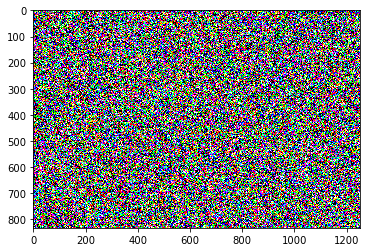

In [160]:
#Generate a random image
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [161]:
iterations=10

In [162]:
x = solve_image(evaluator, iterations, x)

Current loss value: 6534.24755859375
Current loss value: 3464.078857421875
Current loss value: 2563.99462890625
Current loss value: 2157.446044921875
Current loss value: 1951.41015625
Current loss value: 1824.1241455078125
Current loss value: 1716.6593017578125
Current loss value: 1635.4095458984375
Current loss value: 1577.4697265625
Current loss value: 1527.4029541015625


In [163]:
Image.open(spath + 'results/res_at_iteration_9.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Visualizing progress


In [170]:
from IPython.display import HTML
from matplotlib import animation, rc

In [171]:
def animate(i): ax.imshow(Image.open(f'{spath}results/res_at_iteration_{i}.png'))

In [172]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=500)
HTML(anim.to_html5_video())

___________________________________________________________________________________________

In [229]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

______________________________________________________________________________________________

## Recreate style

To obtain a representation of the style of an input image, we use a feature space originally
designed to capture texture information. This feature space is built on top of the filter responses in each layer of the network. It consists of the correlations between the different filter responses over the spatial extent of the feature maps. By including the feature correlations of multiple layers, we obtain a stationary, multi-scale representation of the input image, which captures its texture information but not the global arrangement. This is achieved by the Gram matrix.

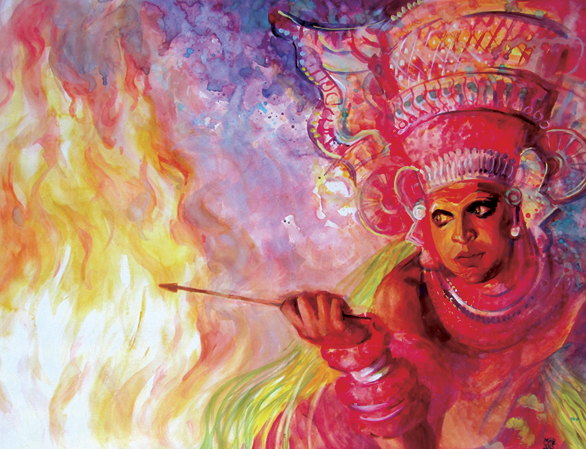

In [126]:
style = Image.open(spath+'/dat.jpg')
style = style.resize(np.divide(style.size,1).astype('int32')); style

In [129]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

Using multiple layers to calculate the loss function

In [61]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,4)]
#layers = model.get_layer('block3_conv1').output

In [62]:
layers

[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(?, 449, 586, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_3/Relu:0' shape=(?, 224, 293, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_3/Relu:0' shape=(?, 112, 146, 256) dtype=float32>]

In [63]:
layers_model = Model(model.input, layers)
#Targs now contains convolution activations of multiple layers
targs = [K.variable(o) for o in layers_model.predict(style_arr)]
#targs = layers_model.predict(style_arr)

In [64]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
#loss = K.mean(metrics.mse(gram_matrix(layers[0]), gram_matrix(targs[0])))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [65]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

In [66]:
iterations=10
x = rand_img(shp); x.shape

(1, 449, 586, 3)

In [67]:
x = solve_image(evaluator, iterations, x)

Current loss value: 8895.9443359375
Current loss value: 1826.681396484375
Current loss value: 880.1153564453125
Current loss value: 517.7521362304688
Current loss value: 368.6851501464844
Current loss value: 267.487548828125
Current loss value: 202.29501342773438
Current loss value: 146.34027099609375
Current loss value: 111.44430541992188
Current loss value: 85.44749450683594


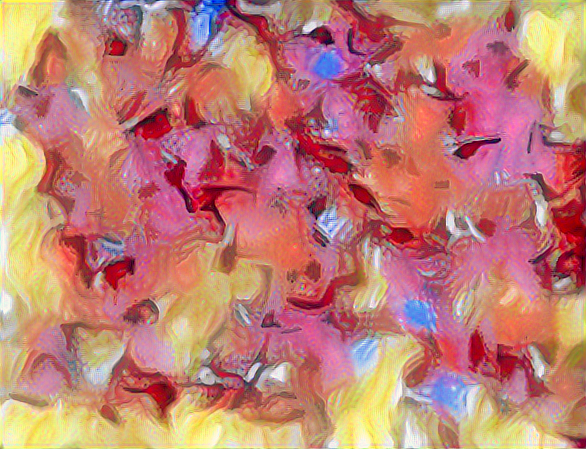

In [68]:
Image.open(spath + 'results/res_at_iteration_9.png')

## Style Transfer

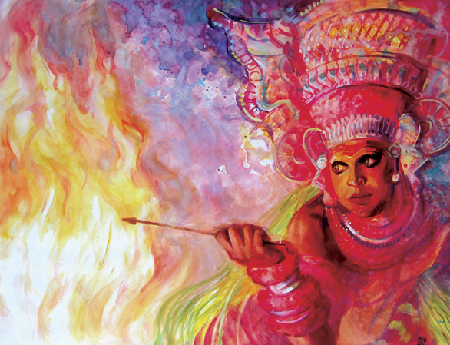

In [210]:
style = Image.open(spath+'/dat.jpg')
style = style.resize(np.divide(style.size,1.3).astype('int32')); style

In [211]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [212]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape; shp

(1, 345, 450, 3)

Normalise sizes of content and style image. 

In [225]:
style.size

(450, 345)

(1, 345, 450, 3)

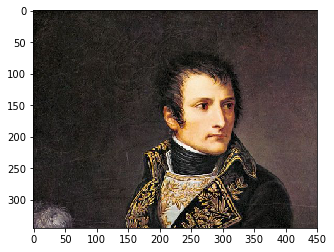

In [226]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src); shp=src.shape; shp

In [230]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,4)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [231]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [232]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [233]:
#Weightage of the gram matrix of each of the layers.
style_wgts = [0.05,0.2,0.2,0.25,0.3]

Create a loss function that combines style loss and content loss. 

In [234]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2, w in zip(style_layers, style_targs, style_wgts))
#Division by 10 assigns the weightage to content loss and style loss
loss += K.mean(metrics.mse(content_layer, content_targ)/10)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [235]:
evaluator = Evaluator(transfer_fn, shp)

In [236]:
iterations=10
x = src

In [237]:
x = solve_image(evaluator, iterations, x)

Current loss value: 2056.42626953125
Current loss value: 969.9959716796875
Current loss value: 790.8746337890625
Current loss value: 629.443359375
Current loss value: 527.1720581054688
Current loss value: 446.1632080078125
Current loss value: 396.774169921875
Current loss value: 355.8865051269531
Current loss value: 318.8902282714844
Current loss value: 293.63616943359375


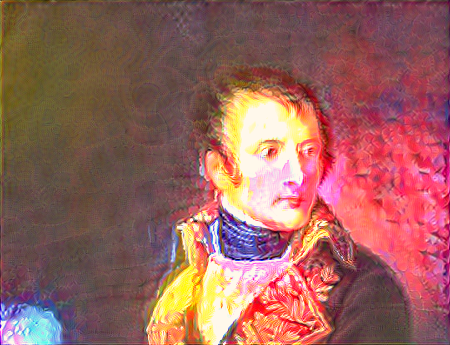

In [238]:
Image.open(spath + 'results/res_at_iteration_9.png')